<a href="https://colab.research.google.com/github/keyvany/decision-making-/blob/main/incremental_decision_making.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ANNArchy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.7/505.7 kB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ANNArchy: filename=annarchy-4.8.2.3-cp311-cp311-linux_x86_64.whl size=2148544 sha256=e9d70129876df86b4b5ee0c4ee89176b9e3b0551932568c00672dd1c76be2655
  Stored in directory: /root/.cache/pip/wheels/f4/c0/4c/b40ff9af74a8eefc7f4fb855fdc6d02de0573c56e2b59416bd
Successfully built ANNArchy


In [2]:
pip install CompNeuroPy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 665.2/665.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.2/334.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 30.6 MB/s eta 0:00:00


In [3]:


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ANNarchy import (
    Neuron,
    Population,
    Projection,
    Synapse,
    setup,
    compile,
    Uniform,
    simulate,

)
import numpy as np
import random
from CompNeuroPy import CompNeuroMonitors, get_full_model, PlotRecordings


# Setup ANNarchy
setup(dt=1.0, num_threads=2)

# General parameters
ITdimension = 10
baseline_it = random.uniform(0.0, 0.1)
response_threshold = 0.5
nr_fish_presentations = 100


feature_name_list = ["DF", "TF", "VF", "MA"]


# define the durations of the events
trial_duration = 200
dopamine_input_duration = 300
deactivate_input_duration = 30
calcium_trace_decline_duration = 100

# Set the dopamine condition
max_dopa = 1.5
baseline_dopa = 0.1
baseline_snc = 0.1
min_dopa = 0.0
K_dip = 0.4


# Neuron models
# SaturatedNeuron=LinearNeuron and NormalizationNeuron=LinearNeuron and LinearNeuronPFC=LinearNeuron
LinearNeuron = Neuron(
    parameters="""
        tau = 20.0
        baseline = 0.0
        noise = 0.0
    """,
    equations="""
        tau*dmp/dt + mp = sum(exc) - sum(inh) + baseline + noise*Uniform(-1.0,1.0)
        r = pos(mp)
    """,
)

DopamineNeuron = Neuron(
    parameters="""
        tau = 20.0
        firing = 0
        inhibition = 0.0
        baseline = 0.0
    """,
    equations="""
        ex_in = if (sum(exc)>0): 1 else: 0
        s_inh = sum(inh)
        aux = if (firing>0): (ex_in)*(pos(1.0-baseline-s_inh) + baseline) + (1-ex_in)*(-10*sum(inh)+baseline)  else: baseline
        tau*dmp/dt + mp =  aux
        r = if (mp>0.0): mp else: 0.0
    """,
)

InputNeuron = Neuron(
    parameters="""
        tau = 1.5
        baseline = 0.0
    """,
    equations="""
        tau*dmp/dt + mp = baseline
        baseline_rec = baseline
        r = if (mp>0.0): mp else: 0.0
    """,
)

# Synapse models
# network populations
PostCovariance = Synapse(
    parameters="""
        tau = 1000.0
        tau_alpha = 10.0
        regularization_threshold = 1.0
        threshold_post = 0.0
        threshold_pre = 0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  + alpha =  pos(post.mp - regularization_threshold)


        trace = (pre.r - mean(pre.r) - threshold_pre) * pos(post.r - mean(post.r) - threshold_post)
    delta = (trace - alpha*pos(post.r - mean(post.r) - threshold_post)*pos(post.r - mean(post.r) - threshold_post)*w)
        tau*dw/dt = delta : min=0
   """,
)

ReversedSynapse = Synapse(
    parameters="""
        reversal = 1.0
    """,
    psp="""
        w*pos(reversal-pre.r)
    """,
)

# DA_typ = 1  ==> D1 type  DA_typ = -1 ==> D2 type
DAPostCovarianceNoThreshold = Synapse(
    parameters="""
        tau=1000.0
        tau_alpha=10.0
        regularization_threshold=1.0
        baseline_dopa = 0.1
        K_burst = 1.0
        K_dip = 0.4
        DA_type = 1
        threshold_pre=0.0
        threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  + alpha = pos(post.mp - regularization_threshold)
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(post.r -  mean(post.r) - threshold_post) * (pre.r - mean(pre.r) - threshold_pre)

    condition_0 = if (trace>0.0) and (w >0.0): 1 else: 0

        dopa_mod = if (DA_type*dopa_sum>0): DA_type*K_burst*dopa_sum else: condition_0*DA_type*K_dip*dopa_sum



        delta = (dopa_mod* trace - alpha*pos(post.r - mean(post.r) - threshold_post)*pos(post.r - mean(post.r) - threshold_post))
        tau*dw/dt = delta : min=0
    """,
)

# Excitatory synapses STN -> GPi
DAPreCovariance_excitatory = Synapse(
    parameters="""
    tau=1000.0
    tau_alpha=10.0
    regularization_threshold=1.0
    baseline_dopa = 0.1
    K_burst = 1.0
    K_dip = 0.4
    DA_type= 1
    threshold_pre=0.0
    threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  = pos( post.mp - regularization_threshold) - alpha
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(pre.r - mean(pre.r) - threshold_pre) * (post.r - mean(post.r) - threshold_post)
        aux = if (trace<0.0): 1 else: 0
        dopa_mod = if (dopa_sum>0): K_burst * dopa_sum else: K_dip * dopa_sum * aux
        delta = dopa_mod * trace - alpha * pos(trace)
        tau*dw/dt = delta : min=0


    """,
)

# Inhibitory synapses GPi -> GPi and STRD2 -> GPe
DAPreCovariance_inhibitory = Synapse(
    parameters="""
    tau=1000.0
    tau_alpha=10.0
    regularization_threshold=1.0
    baseline_dopa = 0.1
    K_burst = 1.0
    K_dip = 0.4
    DA_type= 1
    threshold_pre=0.0
    threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt = pos( -post.mp - regularization_threshold) - alpha
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(pre.r - mean(pre.r) - threshold_pre) * (mean(post.r) - post.r  - threshold_post)
        aux = if (trace>0): 1 else: 0

        dopa_mod = if (DA_type*dopa_sum>0): DA_type*K_burst*dopa_sum else: aux*DA_type*K_dip*dopa_sum

        delta = dopa_mod * trace - alpha * pos(trace)
        tau*dw/dt = delta : min=0
    """,
)

DAPrediction = Synapse(
    parameters="""
        tau = 100000.0
        baseline_dopa = 0.1
   """,
    equations="""
       aux = if (post.sum(exc)>0): 1.0 else: 3.0
       delta = aux*(post.r - baseline_dopa)*pos(pre.r - mean(pre.r))
       tau*dw/dt = delta : min=0
   """,
)


# Populations
# IT Input
IT = Population(name="IT", geometry=(
    ITdimension, ITdimension), neuron=InputNeuron)
IT.tau = 15.0
IT.noise=0.0
IT.baseline = baseline_it

# FEF Input
FEF = Population(name="FEF", geometry=(
    ITdimension, ITdimension), neuron=InputNeuron)
FEF.tau = 10.0
FEF.baseline = baseline_it

# Lateral SNr
SNr = Population(name="SNr", geometry=2, neuron=LinearNeuron)
SNr.tau = 10.0
SNr.noise = 0.0
SNr.baseline = 0

# Reward Input
Reward_Layer = Population(name="Reward_Layer", geometry=1, neuron=InputNeuron)
Reward_Layer.tau = 1.0

# PFC_MTL
MTL = Population(name="PFC_MTL", geometry=(4, 9), neuron=LinearNeuron)
MTL.tau = 1000.0
MTL.noise = 0.0
MTL.baseline = 0.0

# SNc
SNc = Population(name="SNc", geometry=1, neuron=DopamineNeuron)
SNc.tau = 10.0
SNc.firing = 0.0
SNc.baseline = baseline_snc

# Striatum direct pathway
StrD1 = Population(name="StrD1", geometry=(4, 4), neuron=LinearNeuron)
StrD1.tau = 10.0
StrD1.noise = 0.0
StrD1.baseline = 0.4

# Striatum indirect pathway
StrD2 = Population(name="StrD2", geometry=(4, 4), neuron=LinearNeuron)
StrD2.tau = 10.0
StrD2.noise = 0.0
StrD2.baseline = 0.4

# Striatum feedback pathway
StrThal = Population(name="StrThal-PFC", geometry=2, neuron=LinearNeuron)
StrThal.tau = 10.0
StrThal.noise = 0.0
StrThal.baseline = 0.4

# SNr
GPi = Population(name="GPi", geometry =2, neuron=LinearNeuron)
GPi.tau = 10.0
GPi.noise = 0.0
GPi.baseline = 0.0

# STN
STN = Population(name="STN", geometry = (4,4), neuron=LinearNeuron)
STN.tau = 10.0
STN.noise = 0.0
STN.baseline = 0.0

# GPe
GPe = Population(name="GPe", geometry = 2, neuron=LinearNeuron)
GPe.tau = 10.0
GPe.noise = 0.0
GPe.baseline = 0.0

# VA
VA = Population(name="VA-PFC", geometry=2, neuron=LinearNeuron)
VA.tau = 10.0
VA.noise = 0.0001
VA.baseline = 0.0

# PM
PM = Population(name="PM", geometry = 2, neuron=LinearNeuron)
PM.tau = 10.0
PM.noise = 0.0
PM.noise=0.0
#Projections#Projections

# Projections
ITMTL = Projection(pre=IT, post=MTL, target="exc", synapse=PostCovariance)
ITMTL.connect_all_to_all(weights=Uniform(0.3, 0.4))  # Normal(0.3,0.1) )
ITMTL.tau = 20
ITMTL.regularization_threshold = 3.5
ITMTL.tau_alpha = 2.0
ITMTL.baseline_dopa = baseline_dopa
ITMTL.threshold_post = 0.0
ITMTL.thrshold_pre = 1.5

# Thalamocortical Connections
VA_IT = Projection(pre=VA, post=IT, target="exc", synapse=PostCovariance)
VA_IT.connect_all_to_all(weights=Uniform(0.2, 0.3))
VA_IT.tau = 20.0
VA_IT.regularization_threshold = 3.5
VA_IT.tau_alpha = 2.0
VA_IT.baseline_dopa = baseline_dopa
VA_IT.threshold_post = 0.0
VA_IT.threshold_pre = 1.5

#VA_MTL = Projection(pre=VA, post=MTL, target="exc", synapse=PostCovariance)
#VA_MTL.connect_all_to_all(weights=Uniform(0.2, 0.3))
#VA_MTL.tau = 10.0
#VA_MTL.regularization_threshold = 3.5
#VA_MTL.tau_alpha = 2.0
#VA_MTL.baseline_dopa = baseline_dopa
#VA_MTL.threshold_post = 0.0
#VA_MTL.threshold_pre = 1.5

#VA_PM = Projection(pre=VA, post=PM, target="exc", synapse=PostCovariance)
#VA_PM.connect_all_to_all(weights=Uniform(0.2, 0.3))
#VA_PM.tau = 20.0
#VA_PM.regularization_threshold = 3.5
#VA_PM.tau_alpha = 2.0
#VA_PM.baseline_dopa = baseline_dopa
#VA_PM.threshold_post = 0.0
#VA_PM.threshold_pre = 1.5


MTLVA_11 = Projection(pre=MTL[0:8], post=VA[0], target="exc")
MTLVA_11.connect_all_to_all(weights=0.15)
MTLVA_22 = Projection(pre=MTL[8:16], post=VA[1], target="exc")
MTLVA_22.connect_all_to_all(weights=0.15)

IT_StrD1 = Projection(
    pre=IT, post=StrD1, target="exc", synapse=DAPostCovarianceNoThreshold
)
IT_StrD1.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
IT_StrD1.tau = 75.0
IT_StrD1.regularization_threshold = 1.0
IT_StrD1.tau_alpha = 1.0
IT_StrD1.baseline_dopa = baseline_dopa
IT_StrD1.K_dip = 0.4
IT_StrD1.K_burst = 1.0
IT_StrD1.DA_type = 1
IT_StrD1.threshold_pre = 0.15

IT_StrD2 = Projection(
    pre=IT, post=StrD2, target="exc", synapse=DAPostCovarianceNoThreshold
)
IT_StrD2.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
IT_StrD2.tau = 75.0
IT_StrD2.regularization_threshold = 1.0
IT_StrD2.tau_alpha = 1.0
IT_StrD2.baseline_dopa = baseline_dopa
IT_StrD2.K_dip = 0.4
IT_StrD2.K_burst = 1.0
IT_StrD2.DA_type = -1
IT.threshold_pre = 0.15

IT_STN = Projection(pre=IT, post=STN, target="exc",
                    synapse=DAPostCovarianceNoThreshold)
IT_STN.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
IT_STN.tau = 75.0
IT_STN.regularization_threshold = 1.0
IT_STN.tau_alpha = 1.0
IT_STN.baseline_dopa = baseline_dopa
IT_STN.K_dip = 0.4
IT_STN.K_burst = 1.0
IT_STN.DA_type = 1
IT_STN.threshold_pre = 0.15



Reward_LayerSNc = Projection(pre=Reward_Layer, post=SNc, target="exc")
Reward_LayerSNc.connect_all_to_all(weights=1.0)

VAMTL_11 = Projection(pre=VA[0], post=MTL[0:8], target="exc")
VAMTL_11.connect_all_to_all(weights=0.35)
VAMTL_22 = Projection(pre=VA[1], post=MTL[8:16], target="exc")
VAMTL_22.connect_all_to_all(weights=0.35)

VAPM = Projection(pre=VA, post=PM, target="exc")
VAPM.connect_one_to_one(weights=1.0)

StrD1StrD1 = Projection(pre=StrD1, post=StrD1, target="inh")
StrD1StrD1.connect_all_to_all(weights=0.3)

STNSTN = Projection(pre=STN, post=STN, target="inh")
STNSTN.connect_all_to_all(weights=0.3)

MTLMTL = Projection(pre=MTL, post=MTL, target="inh")
MTLMTL.connect_all_to_all(weights=0.1)

PMPM = Projection(pre=PM, post=PM, target="inh")
PMPM.connect_all_to_all(weights=1.0)

StrD2StrD2 = Projection(pre=StrD2, post=StrD2, target="inh")
StrD2StrD2.connect_all_to_all(weights=0.3)

StrThalStrThal = Projection(pre=StrThal, post=StrThal, target="inh")
StrThalStrThal.connect_all_to_all(weights=0.3)

GPi_GPi = Projection(pre=GPi, post=GPi, target="exc", synapse=ReversedSynapse)
GPi_GPi.connect_all_to_all(weights=1.5)

StrD1_GPi = Projection(
    pre=StrD1, post=GPi, target="inh", synapse=DAPreCovariance_inhibitory
)
StrD1_GPi.connect_all_to_all(weights=Uniform(0.3, 0.5))  # Normal(0.025,0.025))
StrD1_GPi.tau = 50.0
StrD1_GPi.regularization_threshold = 1.0
StrD1_GPi.tau_alpha = 1.0
StrD1_GPi.baseline_dopa = baseline_dopa
StrD1_GPi.K_dip = 0.4
StrD1_GPi.threshold_post = 0.15
StrD1_GPi.DA_type = 1

STN_GPi = Projection(
    pre=STN, post=GPi, target="exc", synapse=DAPreCovariance_excitatory
)
STN_GPi.connect_all_to_all(weights=Uniform(0.3, 0.5))  # Normal(0.025,0.025))
STN_GPi.tau = 50.0
STN_GPi.regularization_threshold = 2.6
STN_GPi.tau_alpha = 1.0
STN_GPi.baseline_dopa = baseline_dopa
STN_GPi.K_dip = 0.4
STN_GPi.thresholdpost = -0.15
STN_GPi.DA_type = 1

StrD2_GPe = Projection(
    pre=StrD2, post=GPe, target="inh", synapse=DAPreCovariance_inhibitory
)
StrD2_GPe.connect_all_to_all(weights=Uniform(0.3, 0.5))  # Normal(0.025,0.025))
StrD2_GPe.tau = 50.0
StrD2_GPe.regularization_threshold = 2.0
StrD2_GPe.tau_alpha = 1.0
StrD2_GPe.baseline_dopa = baseline_dopa
StrD2_GPe.K_dip = 0.4
StrD2_GPe.threshold_post = 0.15
StrD2_GPe.DA_type = -1



GPe_GPi = Projection(pre=GPe, post=GPi, target="inh")
GPe_GPi.connect_one_to_one(weights=1.5)

#FEF_SNr = Projection(pre=FEF, post=SNr, target="inh")
#FEF_SNr.connect_one_to_one(weights=1.5)

#SNr_VA = Projection(pre=SNr, post=VA, target="inh")
#SNr_VA.connect_one_to_one(weights=1.5)

GPe_STN = Projection(pre=GPe, post=STN, target="inh", synapse=DAPreCovariance_inhibitory)
GPe_STN.connect_all_to_all(weights=Uniform(0.3, 0.5))

VAStr_Thal = Projection(pre=VA, post=StrThal, target="exc")
VAStr_Thal.connect_one_to_one(weights=1.0)

StrThal_GPe = Projection(pre=StrThal, post=GPe, target="inh")
StrThal_GPe.connect_one_to_one(weights=0.3)

StrThal_GPi = Projection(pre=StrThal, post=GPi, target="inh")
StrThal_GPi.connect_one_to_one(weights=0.3)

#StrThal_MTL = Projection(pre=StrThal, post=MTL, target="inh")
#StrThal_MTL.connect_all_to_all(weights=0.3)

GPi_VA = Projection(pre=GPi, post=VA, target="inh")
GPi_VA.connect_one_to_one(weights=0.7)

SNc_StrD1 = Projection(pre=SNc, post=StrD1, target="dopa")
SNc_StrD1.connect_all_to_all(weights=1.0)

SNc_StrD2 = Projection(pre=SNc, post=StrD2, target="dopa")
SNc_StrD2.connect_all_to_all(weights=1.0)

SNc_GPi = Projection(pre=SNc, post=GPi, target="dopa")
SNc_GPi.connect_all_to_all(weights=0.000001)

SNc_STN = Projection(pre=SNc, post=STN, target="dopa")
SNc_STN.connect_all_to_all(weights=1.0)

SNc_GPe = Projection(pre=SNc, post=GPe, target="dopa")
SNc_GPe.connect_all_to_all(weights=1.0)

SNc_MTL = Projection(pre=SNc, post=MTL, target="dopa")
SNc_MTL.connect_all_to_all(weights=1.0)

SNc_VA = Projection(pre=SNc, post=VA, target="dopa")
SNc_VA.connect_all_to_all(weights=1.0)



#PMIT = Projection(pre=PM, post=IT, target="exc")
#PMIT.connect_all_to_all(weights=0.95)


compile()

ANNarchy 4.8 (4.8.2.3) on linux (posix).
Compiling ...  OK 


In [4]:
# Retrieve the list of populations from the full model
populations = get_full_model()["populations"]

# Print the populations to check the data structure or contents
print(populations)
kol=[]
# Create a dictionary with population names as keys and list ["r"] as values.
mon_dict = {"" + pop: ["r"] for pop in populations}

# Create a monitor object using the dictionary, likely used for tracking performance or other metrics
mon = CompNeuroMonitors(mon_dict)

# Print the monitor dictionary to inspect its structure
print(mon_dict)

['IT', 'FEF', 'SNr', 'Reward_Layer', 'PFC_MTL', 'SNc', 'StrD1', 'StrD2', 'StrThal-PFC', 'GPi', 'STN', 'GPe', 'VA-PFC', 'PM']
{'IT': ['r'], 'FEF': ['r'], 'SNr': ['r'], 'Reward_Layer': ['r'], 'PFC_MTL': ['r'], 'SNc': ['r'], 'StrD1': ['r'], 'StrD2': ['r'], 'StrThal-PFC': ['r'], 'GPi': ['r'], 'STN': ['r'], 'GPe': ['r'], 'VA-PFC': ['r'], 'PM': ['r']}


In [5]:
def get_fish(fish_list, feature_name_list):
    """
    return a dictionary with features and feature values

    Args:
        fish_list: list
            list with all possible fishes consisting of 4 feature values
        feature_name_list: list
            list containing 4 strings, the names of the 4 features (the order corresponds to the order in fish_list)
    """
    input_1 = random.randint(0, 1)

    input_11 = random.randint(
        0, 5
    )
  #
    input_sacc = fish_list[input_1][input_11]

    fish = dict(zip(feature_name_list, input_sacc))
    return fish
def get_true_category(fish):
    important_feature =  "DF"
    important_feature1= "TF"
    important_feature2= "VF"
    """
    returns the of a given fish based on a single feature
    """

    if fish[important_feature]  - fish[important_feature1] < 0.0:
        cat = "A"

    if fish[important_feature] - fish[important_feature1] > 0.0:
        cat = "B"
    if fish[important_feature] - fish[important_feature1] == 0.0:
       if fish[important_feature2]==0.5:
          cat="A"
       else : cat="B"

    return cat
def select_input(feature_name, fish, IT, feature_name_list, baseline_default):
    """
    activates IT neurons based on the presented feature

    Args:
        feature_name: string
            name of the activated feature
        fish: dictionary
            dictionary containing the feature values for the fish features
        IT: ANNarchy population
            the IT population
        feature_name_list: list
            list containing 4 strings, the names of the 4 features (the order corresponds to the order in fish_list)
        baseline_default: float
            default baseline of IT
    """
    # set deafult baseline
    IT.baseline = baseline_default

    # feature name i.e. spatial position defines the group of IT neurons
    nr_IT_neurons = len(IT)
    nr_group_neurons = nr_IT_neurons // (len(feature_name_list))
    neuron_group_idx = feature_name_list.index(feature_name)
    neuron_group = IT[
        int(neuron_group_idx * nr_group_neurons): int(
            (neuron_group_idx + 1) * nr_group_neurons
        )
    ]

    # feature value defines which neurons of neuron group get active --> neuron groups are feature-value selective
    feature_value = fish[feature_name]
    activity_center_idx = ((feature_value - (-1)) /
                           (1 - (-1))) * (nr_group_neurons - 1)

    activity = gauss_1D(
        m=activity_center_idx,
        sig=nr_group_neurons / 10,
        size=nr_group_neurons,
        min=neuron_group.baseline[0],
    )

    # set the activity of the neuron group
    neuron_group.baseline = activity
def gauss_1D(m, sig, size, min):
    """
    returns a 1D gaussian array

    Args:
        m: float
            center/mean of the gaussian along the array indizes
        sig: float
            standard deviation in array indizes
        size: int
            size of the returned array
        min: float
            minimum value
    """
    return np.clip(np.exp(-((np.arange(size) - m) ** 2) / (2 * sig**2)), min, None)


def get_feature_order(feature_name_list):
    """
    return a list with feature names containing the presentation order of the fish features
    """
    idx_arr = np.arange(len(feature_name_list))
    feature_name_arr = np.array(feature_name_list)
    np.random.shuffle(idx_arr)
    return feature_name_arr[idx_arr].tolist()

In [6]:
feature_name_list = ["DF", "TF", "VF", "MA"]
fish_list = [
    [
        [-1.0, 0.0, -1.0, 0.0],
        [-0.5, 0.0, 1.0, 1.0],
        [-0.5, 0.5, 0.5, 1.0],
        [0.0, 0.0, 0.5, 0.0],
        [0.0, 1.0, 1.0, -1.0],
        [0.0, 1.0, 1.0, 0.0],
    ],
    [
        [1.0, 0.0, -1.0, 0.0],
        [1.0, 1.0, 1.0, 0.0],
        [0.5, -0.5, 0.0, -1.0],
        [0.0, -1.0, 1.0, 0.0],
        [1.0, 1.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 1.0],
    ],
]
#creat a list to store the average performances over various runs
all_performance_values=[]

In [7]:


from collections import deque
import numpy as np
performance_percent_list = []
avg_performance_window = 0
average_performance = 0
consecutive_correct = 0
trial_correctness_list = []
performance_percent = 0
mylist = []
ll = [[], []]  # lists to store fish based on selected categories
avg_performance = 0
performance_values = []
average_performance_list = []
performance_percent_list = []
response_threshold = 1.0
trial_duration = 200
dopamine_input_duration = 300
deactivate_input_duration = 30
calcium_trace_decline_duration = 100
nr_fish_presentations = 100
correct_trials = 0  # Initialize the count of correct trials
rolling_window = deque(maxlen=10)  # Define a deque with a maximum length of 10 for the rolling window
baseline_it = 0.1
performance_percent_list = deque(maxlen=10)

record_trial = False  # Initial recording state
chunk_of_trials = []  # Initialize list to store trials

for fing in range(nr_fish_presentations):
    simulate(100)  # Simulate for 100 Ms before recording

    fish = get_fish(fish_list, feature_name_list)
    feature_order = get_feature_order(feature_name_list)
    category_true = get_true_category(fish)
    mon.reset()

    if avg_performance >=0.85:
        break

    for feature_name in feature_order:
        if not record_trial:
            trial_data = []  # Temporary list to store data for the current trial
            record_trial = True

        mon.start()
        select_input(feature_name, fish, IT, feature_name_list, baseline_it)
        simulate(trial_duration)

        response_value = np.max(PM.r)
        response_idx = np.argmax(PM.r)
        print(response_value)

        if response_value > response_threshold or feature_name == feature_order[-1]:
            IT.baseline = baseline_it
            simulate(deactivate_input_duration)

            category_selected = ["A", "B"][response_idx]
            if category_selected == category_true:
                print(f"category_true: {category_true}; category_selected: {category_selected}; after {feature_order.index(feature_name) + 1} features")
                print(f"{fing}th fish is:\n{fish}")
               # print(tria_data)
                if category_selected == "A":
                    ll[0].append(fish)
                elif category_selected == "B":
                    ll[1].append(fish)
                Reward_Layer.baseline = 1
                SNc.firing = 1
                consecutive_correct += 1
                correct_trials += 1
                mylist.append(1)
            else:
                Reward_Layer.baseline = 0
                SNc.firing = 0
                consecutive_correct = 0
                SNc.firing = 0
                mylist.append(0)

            trial_performance = 1 if category_selected == category_true else 0
            performance_values.append(trial_performance)
            trial_data.append(trial_performance)

            rolling_window.append(trial_performance)

            if len(rolling_window) == 10:
                avg_performance = sum(rolling_window) / 10
                print(avg_performance)
                average_performance_list.append(avg_performance)
                b = np.std(average_performance_list)
            simulate(dopamine_input_duration)
            simulate(calcium_trace_decline_duration)

            mon.pause()

            record_trial = False  # Finish recording the current trial
            chunk_of_trials.append(trial_data)  # Add completed trial data to chunks

            break
            mon.reset()

0.6509874263620157
1.0986607068659249
category_true: B; category_selected: B; after 2 features
0th fish is:
{'DF': 1.0, 'TF': 1.0, 'VF': 0.0, 'MA': 0.0}
0.6560948504262493
1.2774143548534396
0.6431366709488282
1.1064035418382148
category_true: B; category_selected: B; after 2 features
2th fish is:
{'DF': 0.0, 'TF': -1.0, 'VF': 1.0, 'MA': 0.0}
0.6029197221690843
0.8979977034096407
1.0303269919503273
0.9268614183587324
2.4173261813232862
category_true: B; category_selected: B; after 2 features
4th fish is:
{'DF': 1.0, 'TF': 1.0, 'VF': 0.0, 'MA': 0.0}
0.24834939238070036
2.7219503461230854
category_true: B; category_selected: B; after 2 features
5th fish is:
{'DF': 1.0, 'TF': 1.0, 'VF': 1.0, 'MA': 0.0}
0.25807048545918637
2.1228667081234724
category_true: B; category_selected: B; after 2 features
6th fish is:
{'DF': 0.5, 'TF': -0.5, 'VF': 0.0, 'MA': -1.0}
0.19733518537889144
0.6366870105841554
0.729348833051694
0.408696318272393
0.2238753626075965
2.406332662506361
category_true: A; categ

In [12]:
from collections import deque
import numpy as np

# Initialize performance tracking variables
performance_percent_list = []  # List to track the performance percentage over time
avg_performance_window = 0  # Variable to hold the average performance in the rolling window
average_performance = 0  # The average performance so far
consecutive_correct = 0  # Count of consecutive correct trials
trial_correctness_list = []  # List to store the correctness of each trial
performance_percent = 0  # Current performance percentage
mylist = []  # Temporary list to store results
ll = [[], []]  # Lists to store fish categorized into two categories (A and B)
performance_values = []  # List to store performance for each trial
average_performance_list = []  # List to store average performance over trials
response_threshold = 1.0  # Threshold for response value to consider a correct response
trial_duration = 200  # Duration of each trial in milliseconds
dopamine_input_duration = 300  # Duration of dopamine input in milliseconds
deactivate_input_duration = 30  # Duration of deactivating input in milliseconds
calcium_trace_decline_duration = 100  # Duration for the calcium trace decline in milliseconds
nr_fish_presentations = 100  # Number of fish presentations
correct_trials = 0  # Initialize the count of correct trials
rolling_window = deque(maxlen=10)  # Rolling window with a maximum length of 10 for calculating average performance
baseline_it = 0.1  # Default baseline for IT neurons could be normalized
performance_percent_list = deque(maxlen=10)  # A deque for the performance percentage with a max length of 10
avg_performance=0
record_trial = False  # Flag indicating whether the current trial is being recorded
chunk_of_trials = []  # Initialize list to store data for a chunk of trials

# Loop through the fish presentations
for fing in range(nr_fish_presentations):
    simulate(100)  # Simulate for 100 ms before recording trial

    # Get fish data and its feature order for classification
    fish = get_fish(fish_list, feature_name_list)
    feature_order = get_feature_order(feature_name_list)
    category_true = get_true_category(fish)  # Get the true category of the fish
    mon.reset()  # Reset the monitor at the start of a new trial

    # If average performance exceeds a certain threshold, stop the loop
    if avg_performance >= 0.85:
        break

    # Loop over the feature order to present each feature to the model
    for feature_name in feature_order:
        if not record_trial:
            trial_data = []  # Initialize trial data list
            record_trial = True  # Start recording the trial

        mon.start()  # Start the monitor

        # Select input and simulate the response for the given feature
        select_input(feature_name, fish, IT, feature_name_list, baseline_it)
        simulate(trial_duration)

        # Get the response value and the index of the selected category
        response_value = np.max(PM.r)
        response_idx = np.argmax(PM.r)
        #print(response_value)

        # If the response value exceeds the threshold or it's the last feature, proceed to classify
        if response_value > response_threshold or feature_name == feature_order[-1]:
            IT.baseline = baseline_it  # Reset baseline for IT neurons
            simulate(deactivate_input_duration)  # Simulate the deactivation period

            # Assign the selected category based on the response index
            category_selected = ["A", "B"][response_idx]

            # Check if the selected category matches the true category
            if category_selected == category_true:
                print(f"category_true: {category_true}; category_selected: {category_selected}; after {feature_order.index(feature_name) + 1} features")
                print(f"{fing}th fish is:\n{fish}")
                # Append the fish to the corresponding category list
                if category_selected == "A":
                    ll[0].append(fish)
                elif category_selected == "B":
                    ll[1].append(fish)

                # Update reward and firing status for correct classification
                Reward_Layer.baseline = 1
                SNc.firing = 1
                consecutive_correct += 1  # Increase the count of consecutive correct trials
                correct_trials += 1  # Increase the count of correct trials overall
                mylist.append(1)  # Add 1 to the list indicating correct response
            else:
                # If the classification was incorrect, update the reward and firing status
                Reward_Layer.baseline = 0
                SNc.firing = 0
                consecutive_correct = 0  # Reset the consecutive correct trials count
                SNc.firing = 0
                mylist.append(0)  # Add 0 to the list indicating incorrect response

            # Calculate trial performance (1 for correct, 0 for incorrect)
            trial_performance = 1 if category_selected == category_true else 0
            performance_values.append(trial_performance)  # Append the performance for the current trial
            trial_data.append(trial_performance)  # Append the performance for this trial to trial_data

            # Add trial performance to the rolling window for calculating average performance
            rolling_window.append(trial_performance)

            # If the rolling window has 10 elements, calculate the average performance
            if len(rolling_window) == 10:
                avg_performance = sum(rolling_window) / 10  # Calculate the average performance
                print(avg_performance)
                average_performance_list.append(avg_performance)  # Store average performance in the list
                b = np.std(average_performance_list)  # Calculate the standard deviation of average performance

            # Simulate dopamine input and calcium trace decline
            simulate(dopamine_input_duration)
            simulate(calcium_trace_decline_duration)

            mon.pause()  # Pause the monitor after the trial

            record_trial = False  # End recording the current trial
            chunk_of_trials.append(trial_data)  # Add the completed trial data to the chunk list

            break  # Break the loop after the trial is completed
            mon.reset()  # Reset the monitor for the next trial

category_true: A; category_selected: A; after 4 features
6th fish is:
{'DF': -1.0, 'TF': 0.0, 'VF': -1.0, 'MA': 0.0}
category_true: A; category_selected: A; after 4 features
7th fish is:
{'DF': 0.0, 'TF': 0.0, 'VF': 0.5, 'MA': 0.0}
0.2
0.2
category_true: A; category_selected: A; after 4 features
11th fish is:
{'DF': 0.0, 'TF': 0.0, 'VF': 0.5, 'MA': 0.0}
0.3
0.3
0.3
0.3
0.3
0.2
0.1
0.1
category_true: B; category_selected: B; after 4 features
19th fish is:
{'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0}
0.2
category_true: B; category_selected: B; after 4 features
20th fish is:
{'DF': 0.0, 'TF': -1.0, 'VF': 1.0, 'MA': 0.0}
0.3
category_true: B; category_selected: B; after 4 features
21th fish is:
{'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0}
0.3
category_true: B; category_selected: B; after 4 features
22th fish is:
{'DF': 1.0, 'TF': 1.0, 'VF': 1.0, 'MA': 0.0}
0.4
0.4
0.4
category_true: A; category_selected: A; after 4 features
25th fish is:
{'DF': 0.0, 'TF': 1.0, 'VF': 1.0, 'MA': 0.0}
0.5
cat

In [8]:
khar=[]
#we can repeat the above cells for as many times as we want to track the average performance over different runs. I did it manually
all_performance_values.append(average_performance_list[-10:])
print(len(all_performance_values))
print(all_performance_values)
c=0

1
[[0.2, 0.2, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.6]]


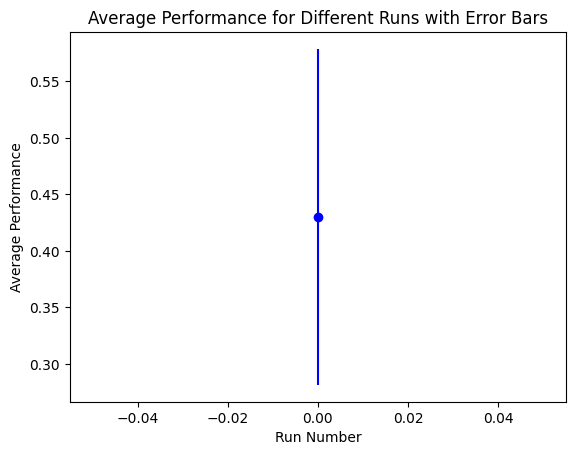

1
[0.2, 0.2, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.6]


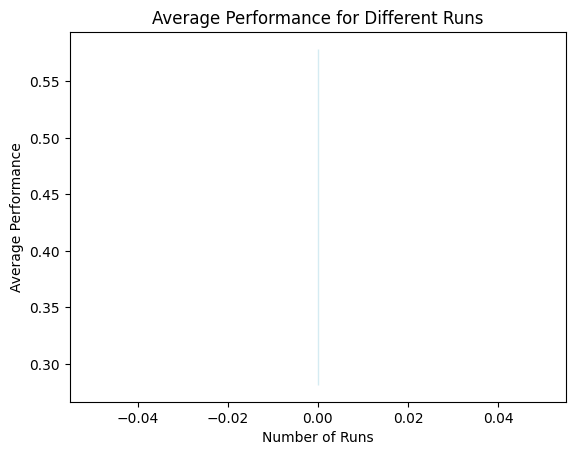

1
[0.2, 0.2, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.6]


In [9]:

std_deviation_list=[]
goh=[]
for performance_values in all_performance_values:
    c=sum(performance_values[-10:]) / len(performance_values[-10:])
    goh.append(c)
    std_deviation = [np.std(performance_values)]
    std_deviation_list.append(performance_values)
    import numpy as np
datapoints=range(0,10*len(goh),10 )
plt.errorbar(datapoints, goh, yerr=std_deviation, fmt='-o', color='blue')
plt.xlabel('Run Number')
plt.ylabel('Average Performance')
plt.title('Average Performance for Different Runs with Error Bars')
plt.show()
#plt.plot(goh)
print(len(goh))
print(performance_values)
import numpy as np
import matplotlib.pyplot as plt

std_deviation_list=[]
goh=[]
for performance_values in all_performance_values:
    c=sum(performance_values[-10:]) / len(performance_values[-10:])
    goh.append(c)
    std_deviation = np.std(performance_values[-10:])
    std_deviation_list.append(std_deviation)

datapoints = np.arange(0, 10*len(goh), 10)
#plt.errorbar(datapoints, goh, yerr=std_deviation_list, fmt='-o', color='blue',label='Mean with Error Margin')
plt.fill_between(datapoints, np.subtract(goh, std_deviation_list), np.add(goh, std_deviation_list),color='lightblue', alpha=0.5) # Adding band around the line plot
plt.plot(datapoints,goh, color='blue')
plt.xlabel('Number of Runs')
plt.ylabel('Average Performance')
plt.title('Average Performance for Different Runs')
plt.show()

#plt.plot(goh)
print(len(goh))
print(performance_values)

In [10]:
# Get recordings and recording times from the monitor
recordings1 = mon.get_recordings()  # Get the current recordings
recording_times1 = mon.get_recording_times()  # Get the times at which recordings were made

Generate fig monitor_recordings_1_chunk0.png... Done

0
Generate fig monitor_recordings_1_chunk1.png... Done

1
Generate fig monitor_recordings_1_chunk2.png... Done

2
Generate fig monitor_recordings_1_chunk3.png... Done

3
Generate fig monitor_recordings_1_chunk4.png... 

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

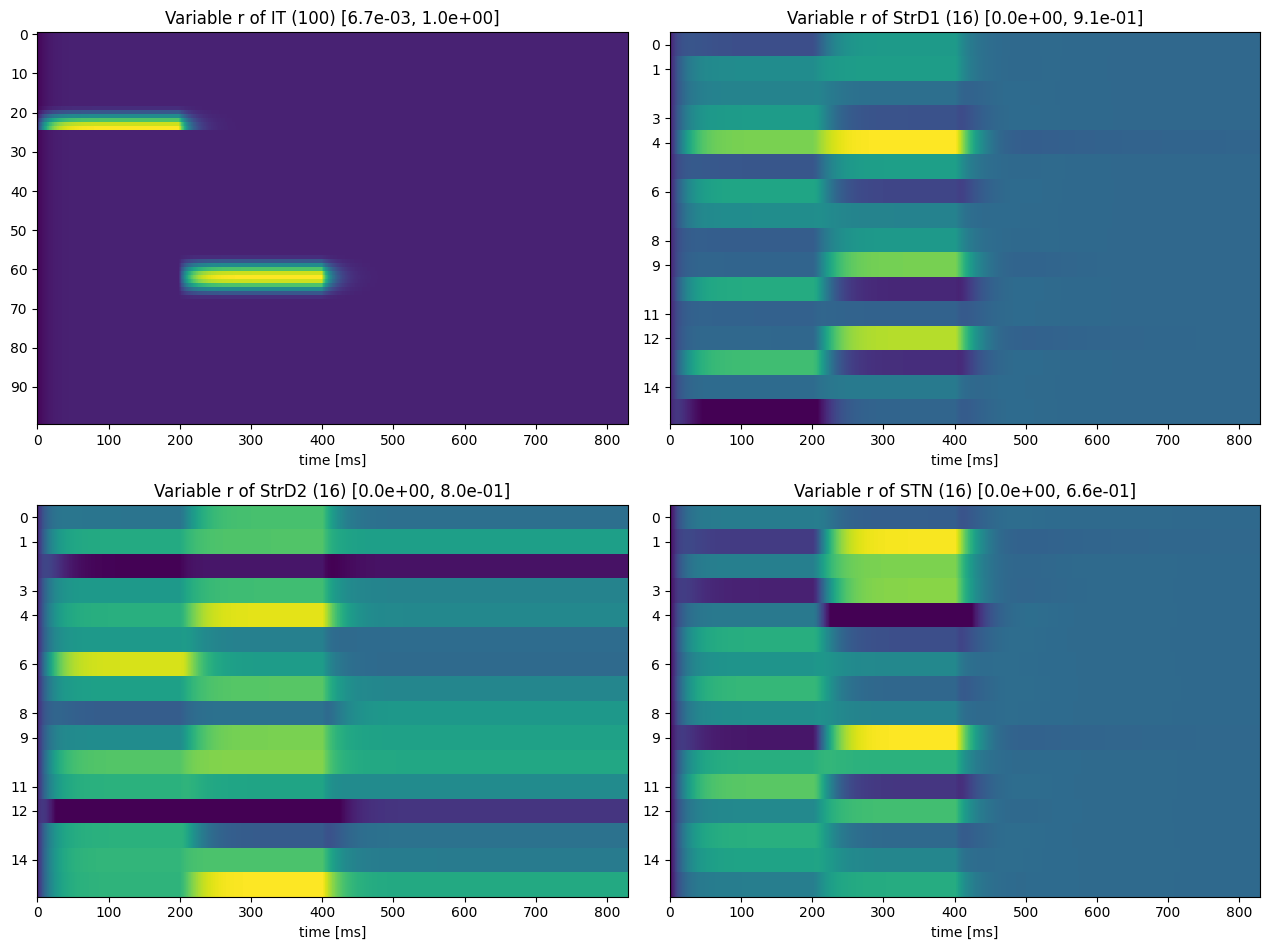

In [11]:
for chunk in range(15):
        ### using plot_recordings which plots the recordings of one chunk
        PlotRecordings(
            figname=f"monitor_recordings_1_chunk{chunk}.png",
            recordings=recordings1,
            #recording_times=recording_times1,
            recording_times=recording_times1,
            shape=(2,2),
            plan={
                "position": [1,2,3,4],
                "compartment": ["IT", "StrD1","StrD2","STN"],
                "variable": ["r", "r", "r", "r"],
                "format": ["matrix", "matrix", "matrix","matrix"],
            },
            chunk=chunk,

        )
        plt.savefig(f"pw3{chunk}.png")
        print(chunk)

Generate fig mon_recordings_2_chunk0.png... Done

0
Generate fig mon_recordings_2_chunk1.png... Done

1
Generate fig mon_recordings_2_chunk2.png... Done

2
Generate fig mon_recordings_2_chunk3.png... Done

3
Generate fig mon_recordings_2_chunk4.png... 

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

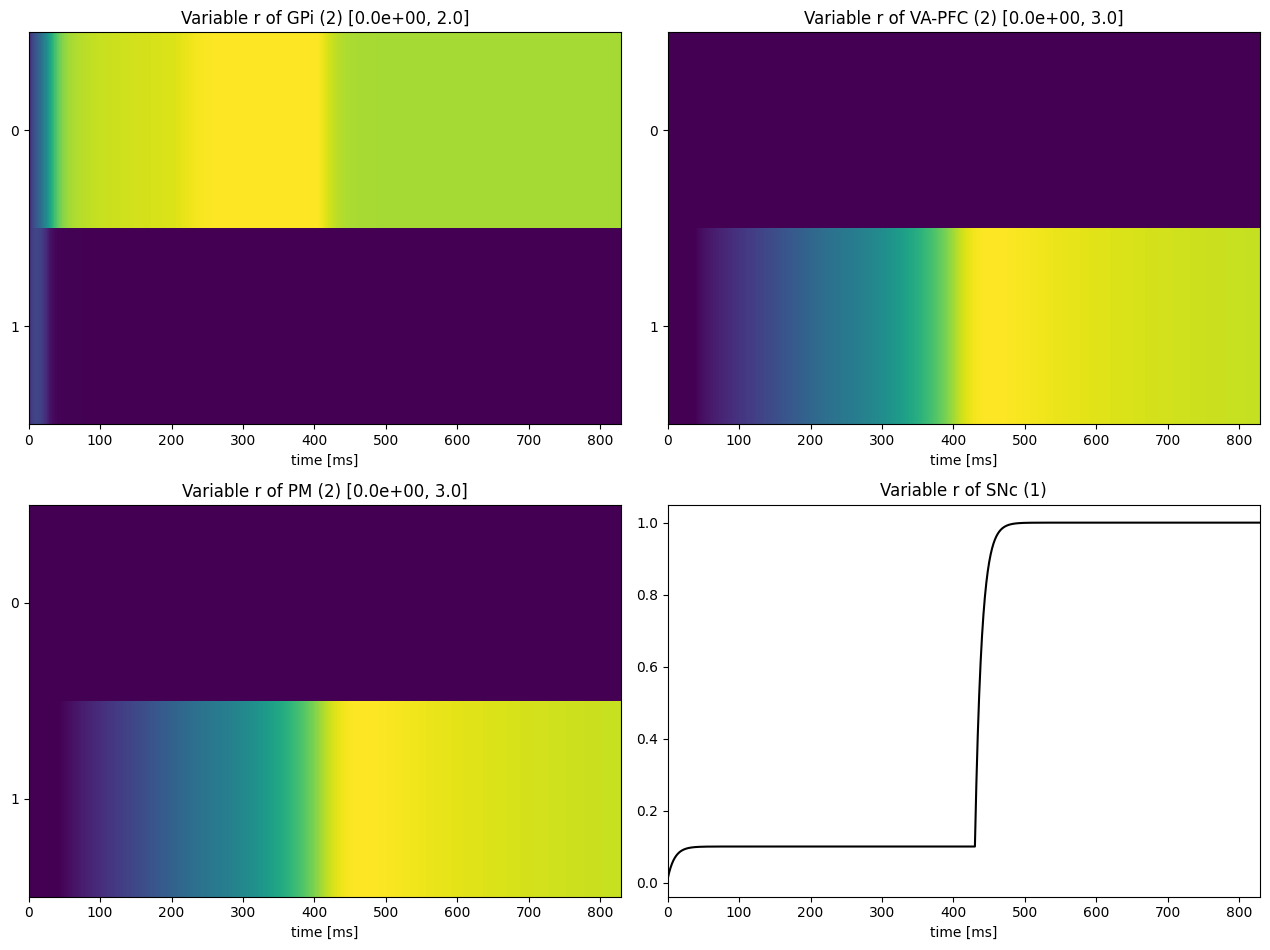

In [12]:
for chunk in range(15):


   PlotRecordings(
            figname=f"mon_recordings_2_chunk{chunk}.png",
            recordings=recordings1,
            recording_times=recording_times1,
            shape=(2,2),
            plan={
                "position": [1,2,3,4],
                "compartment": ["GPi","VA-PFC", "PM", "SNc"],
                "variable": ["r", "r", "r", "r"],
                "format": ["matrix", "matrix", "matrix", "line"],
            },
            chunk=chunk,


   )
   plt.savefig(f"pw3{chunk}.png")
   print(chunk)

In [ ]:
x=recordings1
x[0]['IT;r']
import csv


for x in recordings1:
 for p in populations:
   csv_filename = f"recordings_data_{p}.csv"
   with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow([f"{p};r"])  # Writing header
    for record in recordings1:
        writer.writerow([record[f"{p};r"]])
# Define CSV file name
csv_filename = "recordings_data.csv"

# Save extracted data into a CSV file
with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['IT;r'])  # Writing header
    for record in recordings1:
        writer.writerow([record['IT;r']])  # Writing data row-by-row

print(f"Data saved to {csv_filename}")
#showa how you can extract the data from the recordings

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import csv

# Define the variable StrD1 (it can also be taken as input)
StrD1 = "IT"

# Construct the filename based on StrD1
csv_filename = f"recordings_data_{StrD1}.csv"

# Try to read the CSV file and store it in a DataFrame
try:
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(csv_filename, encoding='utf-8')

    # Print the DataFrame
    print("Data from the CSV file:")
    print(df)

except FileNotFoundError:
    print(f"Error: The file {csv_filename} was not found.")

Error: The file recordings_data_IT.csv was not found.


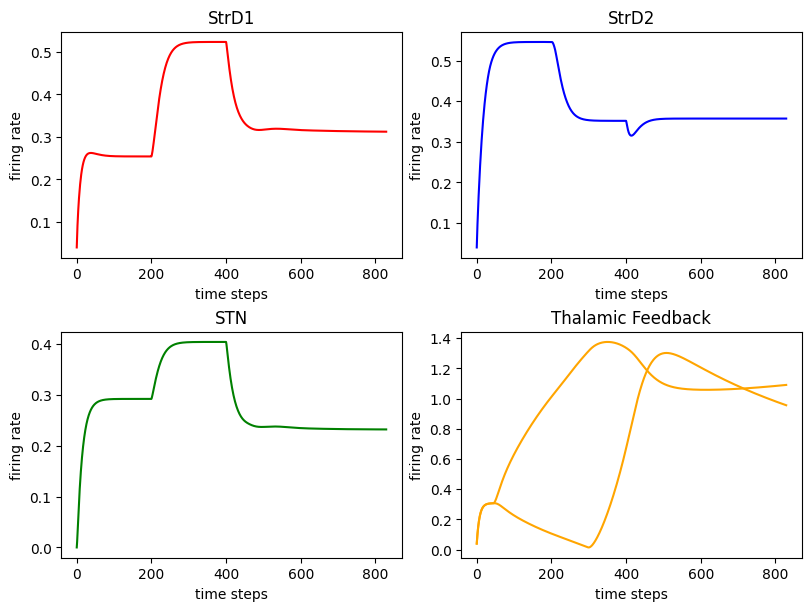

In [13]:
x = recordings1
fig, ax = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True)
ax = ax.flatten()

# Plot Curves displaying the changes in striatum and STN. I added a thalamic feedback:

ax[0].plot(x[2]['StrD1;r'][:,3], color='red')
ax[0].set_title('StrD1')
ax[0].set_xlabel('time steps')
ax[0].set_ylabel('firing rate')

ax[1].plot(x[2]['StrD2;r'][:,3], color='blue')
ax[1].set_title('StrD2')
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('firing rate')

ax[2].plot(x[2]['STN;r'][:,10], color='green')
ax[2].set_title('STN')
ax[2].set_xlabel('time steps')
ax[2].set_ylabel('firing rate')

ax[3].plot(x[2]['StrThal-PFC;r'], color='orange')
ax[3].set_title('Thalamic Feedback')
ax[3].set_xlabel('time steps')
ax[3].set_ylabel('firing rate')


plt.show()

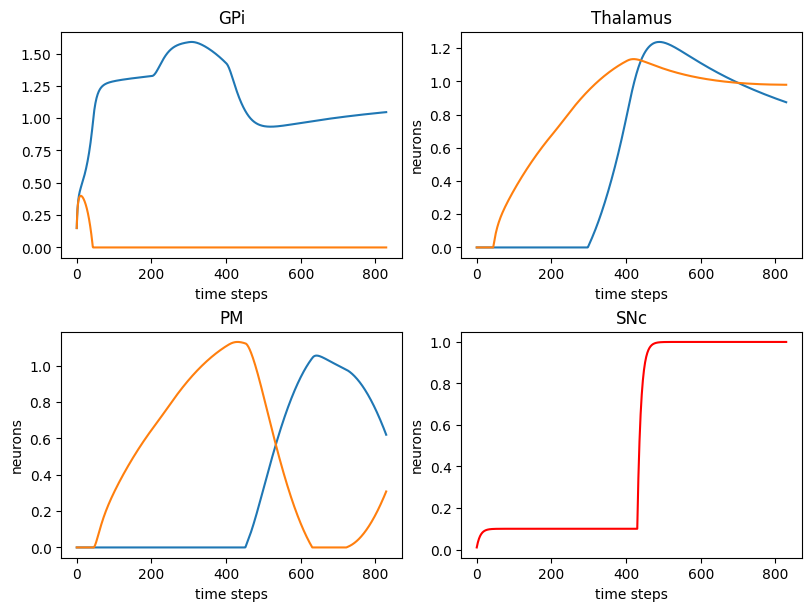

In [14]:
x = recordings1
fig, ax = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True)
ax = ax.flatten()

# Plot Curves for GPi, PM and SNc:

ax[0].plot(x[2]['GPi;r'])
ax[0].set_title('GPi')
ax[0].set_xlabel('time steps')



ax[1].plot(x[2]['VA-PFC;r'])
ax[1].set_title('Thalamus')
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('neurons')

ax[2].plot(x[2]['PM;r'])
ax[2].set_title('PM')
ax[2].set_xlabel('time steps')
ax[2].set_ylabel('neurons')

ax[3].plot(x[2]['SNc;r'], color='red')
ax[3].set_title('SNc')
ax[3].set_xlabel('time steps')
ax[3].set_ylabel('neurons')
plt.show()

In [ ]:
x=recordings1
import numpy as np
for p in populations:
  for i in range(67):
     d = x[i][f"{p};r"]
     np.savetxt('data{}_{}.csv'.format(p,i), d, delimiter=',')

In [ ]:
import pandas as pd
dirpa=pd.read_csv('dataIT_8.csv')
#print(dirpa)
dirp=pd.DataFrame(dirpa)
#dirp.describe()
dota=[]
dota.append(dirp)
import pandas as pd
dirpaa=pd.read_csv('dataGPi_10.csv')
#print(dirpaa)
dirpaa=pd.DataFrame(dirpaa)
#dirpaa.describe()

<ipython-input-117-f5cf342e3090>:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[4].set_xticklabels([0, 200, 400, 600, 800, 1000])


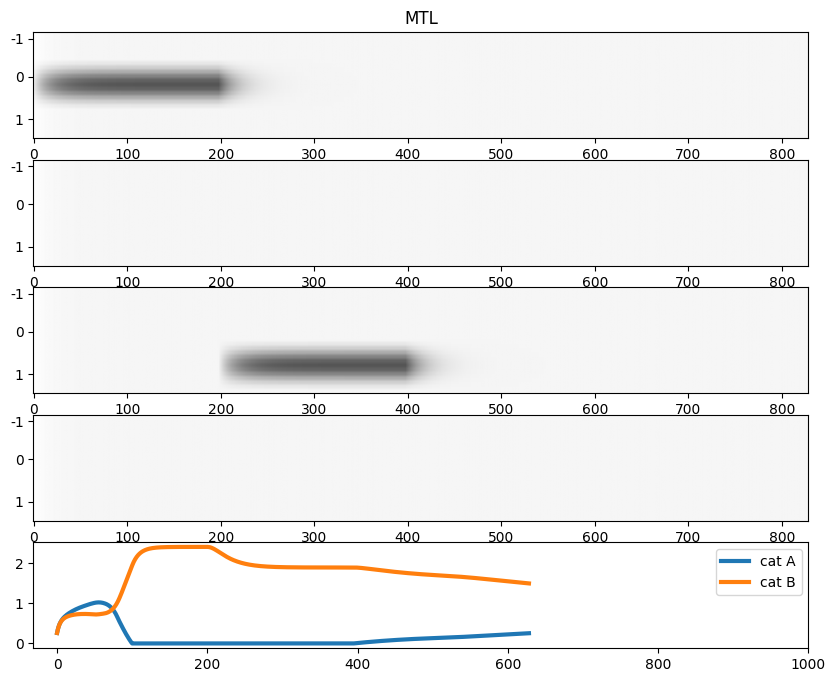

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Function to plot GPi paths and MTL data
def plotGPiPaths2():
    # Define the scaling limits for MTL and GPi data
    MTLscale = [0.0, 1.5]
    GPiscale = [0.1, 0.9]

    # Load MTL data and GPi data (Ensure these are properly defined elsewhere in the code)
    MTL_data = dirp.T  # This is a placeholder for your MTL data
    GPi_0_data = dirpaa  # This is a placeholder for your GPi data
    GPi_1_data = dirpaa  # This is the same GPi data, assuming the same for both

    # Set up the figure and axes for the subplots
    fig, axs = plt.subplots(5, 1, figsize=(10, 8))  # Create 5 subplots stacked vertically
    fig.set_facecolor('white')  # Set the background color of the figure

    # Generate the data points to be plotted (you can adjust this as per your actual data structure)
    datapoints = [i for i, j in enumerate(MTL_data)]

    # Loop through the first 4 subplots to display MTL data in each
    for i in range(4):
        axes = axs[i]  # Get the i-th subplot (axes)

        # Display the MTL data as an image (you can adjust the range and colormap)
        axes.imshow(MTL_data[i * 25:(i + 1) * 25], aspect='auto', cmap='gist_yarg', vmin=MTLscale[0], vmax=MTLscale[1])

        # Customize the y-axis ticks and labels
        axes.set_yticks([1, 10, 20])
        axes.set_yticklabels([-1, 0, 1])

        # Set the title and x-axis label for the first subplot
        if i == 0:
            axes.set_title('MTL')  # Title for MTL data plot
            axes.set_xlabel('features_name[{i}]')  # Label for the x-axis (you can modify `i` for specific features)

    # Calculate the mean of the GPi data (just an example operation)
    dodo = np.mean(dirpaa)  # Placeholder for some computation on GPi data

    # Plot GPi data in the fifth subplot (axs[4])
    for label in zip(['cat A'], ['cat B']):
        axs[4].plot(GPi_0_data, label=label, linewidth=3)  # Plot GPi_0_data with label and line width

        # Set the x-axis ticks and labels for the GPi plot
        axs[4].set_xticklabels([0, 200, 400, 600, 800, 1000])
        axs[4].set_xticks([0, 200, 400, 600, 800, 1000])

        # Show the legend for the GPi plot
        axs[4].legend()

    # Display the plots
    plt.show()

    # Print the data points that were used for plotting
    print(datapoints)

# Call the function to generate the plots
plotGPiPaths2()

# Print the length of the GPi data (ensure dirpaa is properly defined elsewhere in your code)
print(len(dirpaa))

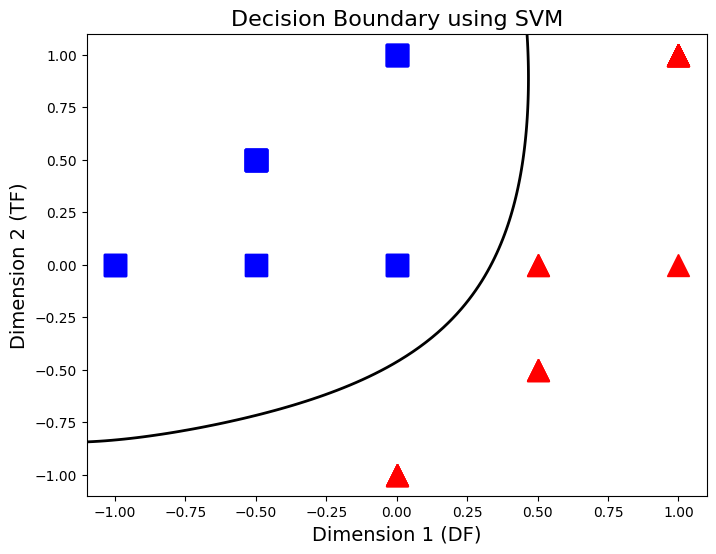

In [15]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Prepare data
ol, al = [], []

for k in range(min(len(ll[0]), len(ll[1]))):
    al.append([ll[0][k]['DF'], ll[0][k]['TF']])  # Class 1 (blue)
    ol.append([ll[1][k]['DF'], ll[1][k]['TF']])  # Class 2 (red)

X = np.array(al + ol)  # Combine both classes
y = np.array([0] * len(al) + [1] * len(ol))  # Labels: Class 0 and Class 1

# Create an SVM model
model = SVC(kernel='rbf')
model.fit(X, y)

# Plot data points
plt.figure(figsize=(8, 6))
for j in range(len(al)):
    plt.plot(al[j][0], al[j][1], 's', markeredgecolor='b', markerfacecolor='b', markersize=16)
for j in range(len(ol)):
    plt.plot(ol[j][0], ol[j][1], '^', markeredgecolor='r', markerfacecolor='r', markersize=16)

# Create mesh for decision boundary
xx, yy = np.meshgrid(np.linspace(-1.1, 1.1, 100), np.linspace(-1.1, 1.1, 100))
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

# Configure plot
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel('Dimension 2 (TF)', fontsize=14)
plt.xlabel('Dimension 1 (DF)', fontsize=14)
plt.title("Decision Boundary using SVM", fontsize=16)
plt.show()

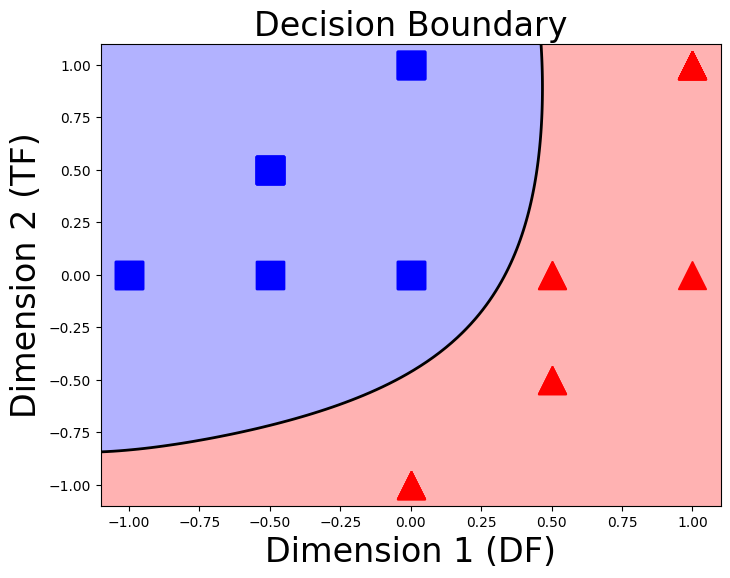

In [16]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Prepare data
ol, al = [], []

for k in range(min(len(ll[0]), len(ll[1]))):
    al.append([ll[0][k]['DF'], ll[0][k]['TF']])  # Class 1 (blue)
    ol.append([ll[1][k]['DF'], ll[1][k]['TF']])  # Class 2 (red)

X = np.array(al + ol)  # Combine both classes
y = np.array([0] * len(al) + [1] * len(ol))  # Labels: Class 0 and Class 1

# Create an SVM model
model = SVC(kernel='rbf')
model.fit(X, y)

# Create mesh for decision boundary
xx, yy = np.meshgrid(np.linspace(-1.1, 1.1, 100), np.linspace(-1.1, 1.1, 100))
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary with filled regions
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf], colors=['blue', 'red'], alpha=0.3)  # Filled regions

# Plot data points
for j in range(len(al)):
    plt.plot(al[j][0], al[j][1], 's', markeredgecolor='b', markerfacecolor='b', markersize=20)
for j in range(len(ol)):
    plt.plot(ol[j][0], ol[j][1], '^', markeredgecolor='r', markerfacecolor='r', markersize=20)

# Plot decision boundary
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

# Configure plot
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel('Dimension 2 (TF)', fontsize=24)
plt.xlabel('Dimension 1 (DF)', fontsize=24)
plt.title("Decision Boundary", fontsize=24)
plt.show()

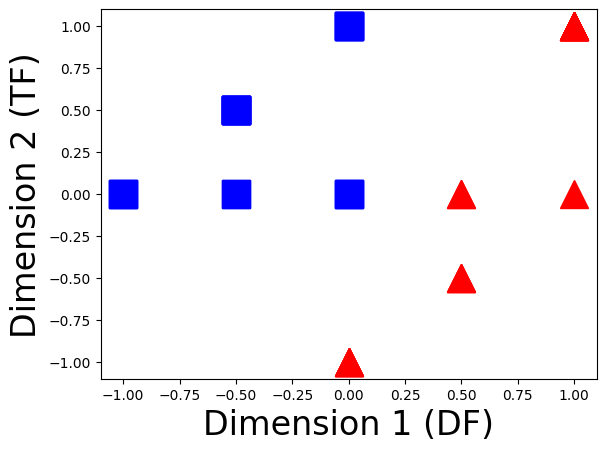

In [17]:


ol=[]
al=[]
for k in range(min(len(ll[0]),len(ll[1]))):
   al.append([ll[0][k]['DF'],ll[0][k]['TF']])

   ol.append([ll[1][k]['DF'],ll[1][k]['TF']])
for j in range(min(len(ll[0]),len(ll[1]))):
   plt.plot(al[j][0], al[j][1], 's', markeredgecolor='b', markerfacecolor='b', markersize=20)
   plt.plot(ol[j][0], ol[j][1], '^', markeredgecolor='r', markerfacecolor='r', markersize=20)
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel('Dimension 2 (TF)', fontsize=24)
plt.xlabel('Dimension 1 (DF)', fontsize=24)
plt.show()

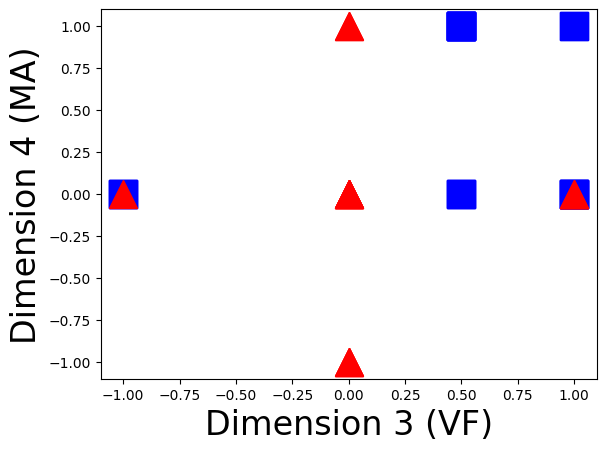

In [18]:

ol=[]
al=[]
for k in range(min(len(ll[0]),len(ll[1]))):
   al.append([ll[0][k]['VF'],ll[0][k]['MA']])

   ol.append([ll[1][k]['VF'],ll[1][k]['MA']])
for j in range(min(len(ll[0]),len(ll[1]))):
   plt.plot(al[j][0], al[j][1], 's', markeredgecolor='b', markerfacecolor='b', markersize=20)
   plt.plot(ol[j][0], ol[j][1], '^', markeredgecolor='r', markerfacecolor='r', markersize=20)
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel('Dimension 4 (MA)', fontsize=24)
plt.xlabel('Dimension 3 (VF)', fontsize=24)
plt.show()